In [1]:
#Basic pre-reqs:
import numpy as np
import torch
import time
from torch.autograd import Variable
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import clear_output
from celluloid import Camera
from copy import deepcopy as copy
%matplotlib inline

import os

#!pip install celluloid

#!export CUDA=cu101 && pip install --upgrade torch-scatter==latest+${CUDA} torch-sparse==latest+${CUDA} -f https://pytorch-geometric.com/whl/torch-1.7.0.html
#!pip install --upgrade torch-geometric

# Mount your google drive in google colab
#from google.colab import drive
#drive.mount('/content/drive')

#%cd '/content/drive/MyDrive/ColabNotebooks/MLAM/GN_ABPs'

import models
import simulate
from importLammps import *

from sklearn.model_selection import train_test_split

import networkx as nx
import torch
from torch import nn
from torch.functional import F
from torch.optim import Adam
from torch_geometric.nn import MetaLayer, MessagePassing
from torch_geometric.utils import to_networkx

from models import OGN, varOGN, make_packer, make_unpacker, get_edge_index

from torch_geometric.data import Data, DataLoader
# from models import get_edge_index

from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR

from tqdm import tqdm

import numpy as onp
onp.random.seed(0)

import pandas as pd


ModuleNotFoundError: No module named 'celluloid'

In [ ]:
importFiles()

batch 10
Running on BD_n=25_dim=2_nt=100000_dt=0.01_ns=1
we remove edges of particles following this probability:


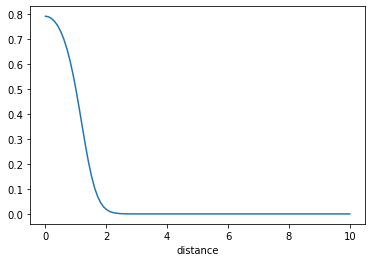

saving_folder  BD_n=25_dim=2_nt=100000_dt=0.01_ns=1_epochs_100_d_cutoff_smooth_1.00_d_cutoff_smth_0.75


FileExistsError: [Errno 17] File exists: 'BD_n=25_dim=2_nt=100000_dt=0.01_ns=1_epochs_100_d_cutoff_smooth_1.00_d_cutoff_smth_0.75'

In [2]:
###########################
##    GLOBAL VARIABLES   ##
###########################

### SIMULATIONS ###

# Potential (see below for options)
sim = 'BD' #'spring'

# Number of simulations to run (it's fast, don't worry):
ns = 1

# Number of nodes
n = 25

# Dimension
dim = 2

# Number of time steps (for some reason later it uses nt/2).
nt = 100000

# Time step
dt = 0.01

# Density of particles
density = 0.6

# train on data every #int_subsampling snapshots
int_subsampling = 10


# removing edges between particles that are further than a cutoff:\
d_cutoff_TF = 'smooth' #'strict' # False # 'smooth' #False/strict/smooth
d_cutoff = 1
d_cutoff_smth = 0.75


### OPTIMIZATION ###
# every step of the minimization the algorithm take a big graph 
# made out of #batch disconnected graphs
# n: number of nodes (particles).
# batch size scales as n^-2 to compensate for the number of messages that goes as n(n-1)
batch = 10 # int(64 * (4 / n)**2) 
print('batch',batch)

# Set up optimizer and training parameters: Use 200 epochs for full version; can use fewer for test.
init_lr = 1e-3
# With total_epochs=200, batch_per_epoch=2000 it takes ~13h.
total_epochs = 100
# number of graphs (snapshots) we include in the test data set
num_graphs_test  = 1000

title = '{}_n={}_dim={}_nt={}_dt={}_ns={}'.format(sim, n, dim, nt, dt, ns)
print('Running on', title)

#############
# FUNCTIONS #
#############

def fermi_func(x):
    # x is the square of the distance 
    return 1/(np.e**((x-d_cutoff**2)/d_cutoff_smth)+1)


if d_cutoff_TF == 'smooth':

    print('we remove edges of particles following this probability:')
    plt.figure()
    x_pl = np.linspace(0,10,100)
    y_pl = fermi_func(x_pl**2)
    plt.plot(x_pl,y_pl)
    plt.xlabel('distance')
    plt.show()
    

# Custom data loader
# HERE WE GENERATE THE CONECTIVITY TENSOR

get_edge_index_fully_connected = get_edge_index(n, sim)

def get_edge_index_cutoff(X_train,d_cutoff, d_cutoff_TF=True):
    
    if d_cutoff_TF == 'strict':

        mat_x = np.tile(X_train[:,0],(len(X_train[:,0]),1))
        mat_y = np.tile(X_train[:,1],(len(X_train[:,1]),1))

        distances = np.square(mat_x-mat_x.T)+np.square(mat_y-mat_y.T)
        distances[distances <= d_cutoff**2 ] = 1
        distances[distances > d_cutoff**2 ] = 0
        np.fill_diagonal(distances, 0)

        edge_index = torch.from_numpy(np.array(np.where(distances)))
        
    elif d_cutoff_TF == 'smooth':
        
        mat_x = np.tile(X_train[:,0],(len(X_train[:,0]),1))
        mat_y = np.tile(X_train[:,1],(len(X_train[:,1]),1))

        distances = np.square(mat_x-mat_x.T)+np.square(mat_y-mat_y.T)
        
        distances[ fermi_func(distances) >= np.random.rand(*distances.shape) ] = 1
        distances[ fermi_func(distances) < np.random.rand(*distances.shape) ] = 0
        
        np.fill_diagonal(distances, 0)

        edge_index = torch.from_numpy(np.array(np.where(distances)))
        
    else:
        edge_index = get_edge_index_fully_connected
        
    return edge_index


# Loss function: This holds definition of our L1 and KL regularizations:

def new_loss(self, g, augment=True, square=False):
  if square:
      return torch.sum((g.y - self.just_derivative(g, augment=augment))**2)
  else:
      base_loss = torch.sum(torch.abs(g.y - self.just_derivative(g, augment=augment)))
      if test in ['_l1_', '_kl_']:
          s1 = g.x[self.edge_index[0]]
          s2 = g.x[self.edge_index[1]]
          if test == '_l1_':
              m12 = self.message(s1, s2)
              regularization = 1e-2
              #Want one loss value per row of g.y:
              normalized_l05 = torch.sum(torch.abs(m12))
              return base_loss, regularization * batch * normalized_l05 / n**2 * n
          elif test == '_kl_':
              regularization = 1
              #Want one loss value per row of g.y:
              tmp = torch.cat([s1, s2], dim=1)  # tmp has shape [E, 2 * in_channels]
              raw_msg = self.msg_fnc(tmp)
              mu = raw_msg[:, 0::2]
              logvar = raw_msg[:, 1::2]
              full_kl = torch.sum(torch.exp(logvar) + mu**2 - logvar)/2.0
              return base_loss, regularization * batch * full_kl / n**2 * n
      return base_loss


# Function to record messages from model


def get_messages(ogn):

    def get_message_info(tmp):
        ogn.cpu()

        s1 = tmp.x[tmp.edge_index[0]] # (pos, vel, ...) of nodes corresponding to indeces tmp.edge_index[0]
        s2 = tmp.x[tmp.edge_index[1]] # same, tmp.edge_index[0] and tmp.edge_index[1] are the nodes forming edges
        
        tmp = torch.cat([s1, s2], dim=1)  # tmp has shape [E, 2 * in_channels]
        if test == '_kl_':
            raw_msg = ogn.msg_fnc(tmp)
            mu = raw_msg[:, 0::2]
            logvar = raw_msg[:, 1::2]

            m12 = mu
        else:
            m12 = ogn.msg_fnc(tmp) # it applies the first NN to the variables of the nodes forming edges
                                   # the output will have dimension msg_dim (100 in this case)

        all_messages = torch.cat((
            s1,
            s2,
            m12), dim=1)
        
        if dim == 2:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d y%d vx%d vy%d q%d m%d'.split(' ')] # labels ['x1', 'y1', 'vx1', 'vy1', 'q1', 'm1', 'x2', 'y2', 'vx2', 'vy2', 'q2', 'm2']
            columns += ['e%d'%(k,) for k in range(msg_dim)]
        elif dim == 3:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d y%d z%d vx%d vy%d vz%d q%d m%d'.split(' ')]
            columns += ['e%d'%(k,) for k in range(msg_dim)]

        return pd.DataFrame(
            data=all_messages.cpu().detach().numpy(),
            columns=columns
        )
    
    

    msg_info = []
    for i, g in enumerate(newtestloader):
        msg_info.append(get_message_info(g))

    msg_info = pd.concat(msg_info)
    msg_info['dx'] = msg_info.x1 - msg_info.x2
    msg_info['dy'] = msg_info.y1 - msg_info.y2
    
    if dim == 2:
        msg_info['r'] = np.sqrt(
            (msg_info.dx)**2 + (msg_info.dy)**2
        )
    elif dim == 3:
        msg_info['dz'] = msg_info.z1 - msg_info.z2
        msg_info['r'] = np.sqrt(
            (msg_info.dx)**2 + (msg_info.dy)**2 + (msg_info.dz)**2
        )
    
    return msg_info


# Function to visualize network

def visualize(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        print("isTensor")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        print("isNotTensor")
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

    
# Functions to import LAMMPs data.

# import glob, re

# def natural_sort_key(s, _nsre=re.compile('([0-9]+)')):
#     return [int(text) if text.isdigit() else text.lower()
#             for text in _nsre.split(s)] 

# def importFiles(filename_glob_pattern, dtype='float', delimiter=None, skip_header=0, usecols=None):
#     sorted_file_list = sorted(glob.glob(filename_glob_pattern), key=natural_sort_key)
#     data = []
#     i=1;
#     for file_path in sorted_file_list:
#         data.append(
#             np.genfromtxt(file_path, delimiter=delimiter, skip_header=skip_header, dtype=dtype, usecols=usecols))
#         i+=1;
#         if (i % 1000) == 0:
#             clear_output(wait=True)
#             print(i)
        
#     print("Imported {} files.".format(len(data)))
        
#     return data

# def lammpsDump2numpy(frames):
#     data = np.asarray(frames);
#     data_attr = np.array([[[np.concatenate((row.tolist()[2:6], np.array([0,1]))) for row in col] for col in data]]);
#     data_accel = np.array([[[row.tolist()[6:8] for row in col] for col in data]]);
    
#     return data_attr, data_accel


saving_folder = title+'_epochs_'+'{0}_d_cutoff_{1}_{2:1.2f}_d_cutoff_smth_{3:1.2f}'.format(total_epochs,d_cutoff_TF,d_cutoff,d_cutoff_smth)
print('saving_folder ',saving_folder)
os.mkdir(saving_folder)

In [3]:
# Run one of the two following cells.

In [4]:
# # Generate simulation data with their JAX simulations (see simulate.py).

# import importlib
# importlib.reload(simulate)

# #Standard simulation sets:
# n_set = [4, 8]
# sim_sets = [
# {'sim': 'r1', 'dt': [5e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
# {'sim': 'r2', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
# {'sim': 'spring', 'dt': [1e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
# {'sim': 'string', 'dt': [1e-2], 'nt': [1000], 'n': [30], 'dim': [2]},
# {'sim': 'charge', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
# {'sim': 'superposition', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
# {'sim': 'damped', 'dt': [2e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
# {'sim': 'discontinuous', 'dt': [1e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
# {'sim': 'BD', 'dt': [1e-5], 'nt': [2001], 'n': n_set, 'dim': [2, 3]},
# ]

# #Select the hand-tuned dt value for a smooth simulation
# # (since scales are different in each potential):
# dt = [ss['dt'][0] for ss in sim_sets if ss['sim'] == sim][0]

# # ??? Why nt//2
# from simulate import SimulationDataset
# s = SimulationDataset(sim, n=n, dim=dim, nt=nt//2, dt=dt) 

# # Update this to your own dataset, or regenerate:
# base_str = './'
# data_str = title
# s.simulate(ns)

# # data has [simulation ID, time, particle ID, [posx, posy, velx, vely, charge, mass]]
# data_attr  = s.data
# data_accel = s.get_acceleration()

# print("Attr shape: [simulation ID, time, particle ID, [posx, posy, velx, vely, charge, mass]] ")
# print(data_attr.shape)
# print("Accl shape: [simulation ID, time, particle ID, [accelx, accely]] ")
# print(data_accel.shape)


In [2]:
# Use LAMMPs simulation data

import importlib
importlib.reload(simulate)


#Standard simulation sets:
n_set = [4, 8]
sim_sets = [
{'sim': 'r1', 'dt': [5e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'r2', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'spring', 'dt': [1e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'string', 'dt': [1e-2], 'nt': [1000], 'n': [30], 'dim': [2]},
{'sim': 'charge', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'superposition', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'damped', 'dt': [2e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'discontinuous', 'dt': [1e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'BD', 'dt': [0.01], 'nt': [100000], 'n': n_set, 'dim': [2, 3]},
]

# Import LAMMPs data (passive system, Pe=1e-6).
fileNamePatt="../../lammps/data/20210802_small-system_passive-attractive/Tsim1.00e+07_dt1.00e-05_N2.50e+01_phi6.00e-01_Pe1.00e-06_Fp2.40e+01_KT1.00e+00_Dt1.50e+00/Frames/frame.*0000"
# fileNamePatt="../../lammps/data/20210310_small_system/Tsim1.00e+07_dt1.00e-05_N2.50e+01_phi6.00e-01_Pe1.00e-06_Fp2.40e+01_KT2.90e-01_Dt1.50e+00/Frames/frame.*00000"


frames = importFiles(fileNamePatt, dtype=float, delimiter=" ", skip_header=9, usecols=range(0,8))

# Transform LAMMPs data to PyTorch format:
# data_attr: [simulation ID, time, particle ID, [posx, posy, velx, vely, charge, mass]]
# data_acccel: [simulation ID, time, particle ID, [accelx, accely]]



# data = np.asarray(frames);
# data_attr = np.array([[[np.concatenate((row.tolist()[2:6], np.array([0,1]))) for row in col] for col in data]]);
# data_accel = np.array([[[row.tolist()[6:8] for row in col] for col in data]]);

data_attr, data_accel = lammpsDump2numpy(frames)

print("Attr shape: {} ".format(data_attr.shape))
print("Accl shape: {} ".format(data_accel.shape))

1000
Imported 1000 files.
Attr shape: (1, 1000, 25, 6) 
Accl shape: (1, 1000, 25, 2) 


In [6]:
# Put data in PyTorch format
X = torch.from_numpy(np.concatenate([data_attr[:,i] for i in range(0, data_attr.shape[1], int_subsampling)]))
y = torch.from_numpy(np.concatenate([data_accel[:, i] for i in range(0, data_accel.shape[1], int_subsampling)]))

X=X.type(torch.FloatTensor)
y=y.type(torch.FloatTensor)

print("Attr. (X) shape: {}".format(X.shape))
print("Accl. (y) shape: {}".format(y.shape))

Attr. (X) shape: torch.Size([10000, 25, 6])
Accl. (y) shape: torch.Size([10000, 25, 2])


In [7]:
# Here we divide train and test data, by default it selects 25% of the data as
# test data. It seems that this is the last 25% of the systems time evolution.
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([7500, 25, 6])
torch.Size([2500, 25, 6])
torch.Size([7500, 25, 2])
torch.Size([2500, 25, 2])


# **Training**

In [8]:

# L1 regularization

aggr = 'add'
hidden = 300
test = '_l1_'

#This test applies an explicit bottleneck:
msg_dim = 100

n_f = data_attr.shape[3]


In [9]:


# Initiate the model

#######
# GPU #
#######

# if test == '_kl_':
#     ogn = varOGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cuda()
# else:
#     ogn = OGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cuda()

# messages_over_time = []
# ogn = ogn.cuda()

# Test the model
# _q = Data(
#     x=X_train[0].cuda(),
#     edge_index=edge_index.cuda(),
#     y=y_train[0].cuda())
# ogn(_q.x, _q.edge_index), ogn.just_derivative(_q).shape, _q.y.shape, ogn.loss(_q), 



#######
# CPU #
#######

if test == '_kl_':
    ogn = varOGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cpu()
else:
    ogn = OGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cpu()

messages_over_time = []
ogn = ogn.cpu()



In [9]:

# # Test the model
# _q = Data(
#     x=X_train[0].cpu(),
#     edge_index=edge_index.cpu(),
#     y=y_train[0].cpu())
# ogn(_q.x, _q.edge_index), ogn.just_derivative(_q).shape, _q.y.shape, ogn.loss(_q), 


In [10]:


## Set up training

time_1 = time.time()

# one minibatch has #batch disconnected graphs
trainloader = DataLoader(
    [Data(
        Variable(X_train[i]),
        edge_index=get_edge_index_cutoff(X_train[i],d_cutoff,d_cutoff_TF=d_cutoff_TF),
        y=Variable(y_train[i])) for i in range(len(y_train))],
    batch_size=batch,
    shuffle=True
)


testloader = DataLoader(
    [Data(
        X_test[i],
        edge_index=get_edge_index_cutoff(X_test[i],d_cutoff,d_cutoff_TF=d_cutoff_TF),
        y=y_test[i]) for i in range(len(y_test))],
    batch_size=1024,
    shuffle=True
)

time_2 = time.time()

print('computation time: ', time_2-time_1)




/home/barri/miniconda3/envs/mlam_cpu/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: overflow encountered in power


computation time:  1.1621382236480713


In [11]:

print('batch',batch)
print('len(y_train)',len(y_train))
# print('ginput.batch',ginput.batch)


i=0
for ginput in trainloader:     # Trainloader has the 1500 samples (pos vel edge index, ...).
    if i >= 3:
        break
    print('number of edges in a batch in the fully conencted case: n*(n-1)*batch ', n*(n-1)*batch)
    print('number of edges in this batch: ',np.shape(ginput.edge_index))
    
    i+=1
    

batch 10
len(y_train) 7500
number of edges in a batch in the fully conencted case: n*(n-1)*batch  6000
number of edges in this batch:  torch.Size([2, 356])
number of edges in a batch in the fully conencted case: n*(n-1)*batch  6000
number of edges in this batch:  torch.Size([2, 335])
number of edges in a batch in the fully conencted case: n*(n-1)*batch  6000
number of edges in this batch:  torch.Size([2, 310])


In [12]:
print(len(trainloader.dataset))
print(len(testloader.dataset))

# edge_index has dimensions [2, num_nodes^2 - num_nodes]
print('links of fully connected graph: ',n*(n-1))
print(trainloader.dataset[0])
print(testloader.dataset[0])

7500
2500
links of fully connected graph:  600
Data(edge_index=[2, 39], x=[25, 6], y=[25, 2])
Data(edge_index=[2, 36], x=[25, 6], y=[25, 2])


In [13]:

# We'll use OneCycleLR for fast training:

opt = torch.optim.Adam(ogn.parameters(), lr=init_lr, weight_decay=1e-8)

# batch_per_epoch = int(1000*10 / (batch/32.0))
batch_per_epoch = int(len(trainloader.dataset)/batch) 

print('batch_per_epoch',batch_per_epoch)
print('batch',batch)
print('batch*batch_per_epoch',batch*batch_per_epoch)
print('len(trainloader.dataset)',len(trainloader.dataset))
print('len(y_train)',len(y_train))


batch_per_epoch 750
batch 10
batch*batch_per_epoch 7500
len(trainloader.dataset) 7500
len(y_train) 7500


In [14]:

sched = OneCycleLR(opt, max_lr=init_lr,
                  steps_per_epoch=batch_per_epoch,#len(trainloader),
                  epochs=total_epochs, final_div_factor=1e5)

epoch = 0

# Organize the recording of messages over time This is for fitting the forces, and extracting laws:

test_idxes = onp.random.randint(0, len(X_test), num_graphs_test)



#Record messages over test dataset here:
# 1000 snapshots taken at random (if 4 particles this is 12000 messages)

newtestloader = DataLoader(
    [Data(
        X_test[i],
        edge_index=get_edge_index_cutoff(X_test[i],d_cutoff,d_cutoff_TF=d_cutoff_TF),
        y=y_test[i]) for i in test_idxes],
    batch_size=len(X_test),
    shuffle=False
)

# idxarr=-1*np.ones((11,151), int);

### Train the model:
# Training loop
recorded_models = []
recorded_times = []
recorded_loss = []


/home/barri/miniconda3/envs/mlam_cpu/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: overflow encountered in power


In [15]:


start_time = time.time()
for epoch in tqdm(range(epoch, total_epochs)):
    ogn.cpu()
    total_loss = 0.0
    i = 0
    num_items = 0
    while i < batch_per_epoch:
        for ginput in trainloader:     # Trainloader has the 1500 samples (pos vel edge index, ...).
            if i >= batch_per_epoch:
                break
            opt.zero_grad()
            ginput.x = ginput.x.cpu()
            ginput.y = ginput.y.cpu()
            ginput.edge_index = ginput.edge_index.cpu()
            ginput.batch = ginput.batch.cpu()
            if test in ['_l1_', '_kl_']:
                loss, reg = new_loss(ogn, ginput, square=False)
                ((loss + reg)/int(ginput.batch[-1]+1)).backward()
            else:
                loss = ogn.loss(ginput, square=False)
                (loss/int(ginput.batch[-1]+1)).backward()
            opt.step()
            sched.step()
            total_loss += loss.item()
            
#             idxarr[epoch,i]= ginput.x[0,4]
            
            i += 1
            print("Epoch: {} ({}%) - {}".format(epoch, 100*i/batch_per_epoch, ginput.x[0,4]), flush=True, end='\r')
            num_items += int(ginput.batch[-1]+1)

    cur_loss = total_loss/num_items
    print('cur_loss',cur_loss)
    cur_msgs = get_messages(ogn)
    cur_msgs['epoch'] = epoch
    cur_msgs['loss'] = cur_loss
    messages_over_time.append(cur_msgs)
    
    ogn.cpu()

    recorded_models.append(ogn.state_dict()) # it saves #epoch copies of the last model!!!
    recorded_times.append(epoch)
    recorded_loss.append(cur_loss)
    
    torch.save(ogn.state_dict(), os.path.join(saving_folder, 'epoch-{0}.pth'.format(epoch)))


  0%|          | 0/100 [00:00<?, ?it/s]

cur_loss 337.84993232421874%) - 0.000


  1%|          | 1/100 [00:09<15:30,  9.40s/it]

cur_loss 337.84767418619793%) - 0.000


  2%|▏         | 2/100 [00:18<15:19,  9.38s/it]

cur_loss 337.84844134114586%) - 0.000


  3%|▎         | 3/100 [00:28<15:18,  9.47s/it]

cur_loss 337.84886360677086%) - 0.000


  4%|▍         | 4/100 [00:37<14:57,  9.35s/it]

cur_loss 337.84955175781256%) - 0.000


  5%|▌         | 5/100 [00:46<14:41,  9.28s/it]

cur_loss 337.84941959635415%) - 0.000


  6%|▌         | 6/100 [00:55<14:22,  9.18s/it]

cur_loss 337.84747376302084%) - 0.000


  7%|▋         | 7/100 [01:04<14:15,  9.20s/it]

cur_loss 337.84902802734376%) - 0.000


  8%|▊         | 8/100 [01:14<14:11,  9.26s/it]

cur_loss 337.84704746093756%) - 0.000


  9%|▉         | 9/100 [01:23<13:51,  9.14s/it]

cur_loss 337.84969570312566%) - 0.000


 10%|█         | 10/100 [01:32<13:48,  9.21s/it]

cur_loss 337.847740299479146%) - 0.000


 11%|█         | 11/100 [01:41<13:30,  9.10s/it]

cur_loss 337.847404785156246%) - 0.000


 12%|█▏        | 12/100 [01:50<13:15,  9.04s/it]

cur_loss 337.847059928385466%) - 0.000


 13%|█▎        | 13/100 [01:59<13:11,  9.10s/it]

cur_loss 337.847960026041766%) - 0.000


 14%|█▍        | 14/100 [02:09<13:15,  9.25s/it]

cur_loss 337.848752669270866%) - 0.000


 15%|█▌        | 15/100 [02:18<13:10,  9.30s/it]

cur_loss 337.847075846354266%) - 0.000


 16%|█▌        | 16/100 [02:27<13:05,  9.35s/it]

cur_loss 337.846894108072956%) - 0.000


 17%|█▋        | 17/100 [02:37<12:56,  9.36s/it]

cur_loss 337.848463834635466%) - 0.000


 18%|█▊        | 18/100 [02:46<12:46,  9.35s/it]

cur_loss 337.849076269531266%) - 0.000


 19%|█▉        | 19/100 [02:55<12:30,  9.27s/it]

cur_loss 337.847653548177166%) - 0.000


 20%|██        | 20/100 [03:04<12:14,  9.18s/it]

cur_loss 337.847864290364566%) - 0.000


 21%|██        | 21/100 [03:13<12:02,  9.15s/it]

cur_loss 337.847153613281256%) - 0.000


 22%|██▏       | 22/100 [03:22<11:40,  8.98s/it]

cur_loss 337.847446484375666%) - 0.000


 23%|██▎       | 23/100 [03:31<11:32,  8.99s/it]

cur_loss 337.846751204427166%) - 0.000


 24%|██▍       | 24/100 [03:40<11:28,  9.05s/it]

cur_loss 337.848802018229156%) - 0.000


 25%|██▌       | 25/100 [03:49<11:22,  9.09s/it]

cur_loss 337.851542285156266%) - 0.000


 26%|██▌       | 26/100 [03:58<11:12,  9.08s/it]

cur_loss 337.846935319010466%) - 0.000


 27%|██▋       | 27/100 [04:08<11:12,  9.21s/it]

cur_loss 337.848051725260466%) - 0.000


 28%|██▊       | 28/100 [04:17<10:53,  9.07s/it]

cur_loss 337.854396256510466%) - 0.000


 29%|██▉       | 29/100 [04:26<10:45,  9.09s/it]

cur_loss 337.849024316406266%) - 0.000


 30%|███       | 30/100 [04:35<10:39,  9.14s/it]

cur_loss 337.850465071614566%) - 0.000


 31%|███       | 31/100 [04:45<10:38,  9.25s/it]

cur_loss 337.847011165364566%) - 0.000


 32%|███▏      | 32/100 [04:54<10:36,  9.36s/it]

cur_loss 337.847416438802166%) - 0.000


 33%|███▎      | 33/100 [05:03<10:26,  9.35s/it]

cur_loss 337.846023990885446%) - 0.000


 34%|███▍      | 34/100 [05:12<10:09,  9.23s/it]

cur_loss 337.846693750.06666%) - 0.000


 35%|███▌      | 35/100 [05:22<10:02,  9.27s/it]

cur_loss 337.846181542968746%) - 0.000


 36%|███▌      | 36/100 [05:31<09:51,  9.25s/it]

cur_loss 337.845911523437566%) - 0.000


 37%|███▋      | 37/100 [05:40<09:38,  9.18s/it]

cur_loss 337.846757226562566%) - 0.000


 38%|███▊      | 38/100 [05:49<09:29,  9.19s/it]

cur_loss 337.847232161458356%) - 0.000


 39%|███▉      | 39/100 [05:58<09:18,  9.16s/it]

cur_loss 337.846486035156266%) - 0.000


 40%|████      | 40/100 [06:08<09:11,  9.19s/it]

cur_loss 337.847660091145866%) - 0.000


 41%|████      | 41/100 [06:17<09:01,  9.18s/it]

cur_loss 337.846660188802166%) - 0.000


 42%|████▏     | 42/100 [06:26<08:54,  9.22s/it]

cur_loss 337.846662109375666%) - 0.000


 43%|████▎     | 43/100 [06:35<08:43,  9.18s/it]

cur_loss 337.846832226562566%) - 0.000


 44%|████▍     | 44/100 [06:44<08:34,  9.18s/it]

cur_loss 337.847149348958346%) - 0.000


 45%|████▌     | 45/100 [06:53<08:21,  9.12s/it]

cur_loss 337.845728645833336%) - 0.000


 46%|████▌     | 46/100 [07:02<08:12,  9.12s/it]

cur_loss 337.847017805989666%) - 0.000


 47%|████▋     | 47/100 [07:13<08:21,  9.47s/it]

cur_loss 337.846516471354166%) - 0.000


 48%|████▊     | 48/100 [07:23<08:17,  9.57s/it]

cur_loss 337.845637272135436%) - 0.000


 49%|████▉     | 49/100 [07:32<08:00,  9.42s/it]

cur_loss 337.845014127604146%) - 0.000


 50%|█████     | 50/100 [07:41<07:46,  9.33s/it]

cur_loss 337.845985091145856%) - 0.000


 51%|█████     | 51/100 [07:51<07:44,  9.47s/it]

cur_loss 337.845544173177166%) - 0.000


 52%|█████▏    | 52/100 [08:00<07:28,  9.34s/it]

cur_loss 337.845292285156236%) - 0.000


 53%|█████▎    | 53/100 [08:09<07:24,  9.45s/it]

cur_loss 337.845673339843766%) - 0.000


 54%|█████▍    | 54/100 [08:19<07:16,  9.48s/it]

cur_loss 337.845984700520836%) - 0.000


 55%|█████▌    | 55/100 [08:28<06:57,  9.28s/it]

cur_loss 337.845353580729266%) - 0.000


 56%|█████▌    | 56/100 [08:37<06:49,  9.31s/it]

cur_loss 337.846236588541766%) - 0.000


 57%|█████▋    | 57/100 [08:46<06:36,  9.21s/it]

cur_loss 337.845818847656236%) - 0.000


 58%|█████▊    | 58/100 [08:55<06:25,  9.17s/it]

cur_loss 337.846374121093736%) - 0.000


 59%|█████▉    | 59/100 [09:04<06:14,  9.13s/it]

cur_loss 337.845629915364666%) - 0.000


 60%|██████    | 60/100 [09:13<06:03,  9.08s/it]

cur_loss 337.843615364583346%) - 0.000


 61%|██████    | 61/100 [09:22<05:52,  9.05s/it]

cur_loss 337.845256901041766%) - 0.000


 62%|██████▏   | 62/100 [09:31<05:44,  9.08s/it]

cur_loss 337.843860872395856%) - 0.000


 63%|██████▎   | 63/100 [09:40<05:35,  9.06s/it]

cur_loss 337.843908007812566%) - 0.000


 64%|██████▍   | 64/100 [09:49<05:28,  9.11s/it]

cur_loss 337.845347102864666%) - 0.000


 65%|██████▌   | 65/100 [09:59<05:23,  9.24s/it]

cur_loss 337.844155110677166%) - 0.000


 66%|██████▌   | 66/100 [10:08<05:16,  9.30s/it]

cur_loss 337.843799902343736%) - 0.000


 67%|██████▋   | 67/100 [10:18<05:09,  9.37s/it]

cur_loss 337.844017708333356%) - 0.000


 68%|██████▊   | 68/100 [10:27<05:00,  9.40s/it]

cur_loss 337.843452832031236%) - 0.000


 69%|██████▉   | 69/100 [10:37<04:50,  9.37s/it]

cur_loss 337.844565755208356%) - 0.000


 70%|███████   | 70/100 [10:47<04:44,  9.50s/it]

cur_loss 337.844232096354266%) - 0.000


 71%|███████   | 71/100 [10:56<04:36,  9.53s/it]

cur_loss 337.842792057291666%) - 0.000


 72%|███████▏  | 72/100 [11:06<04:31,  9.70s/it]

cur_loss 337.844133854166676%) - 0.000


 73%|███████▎  | 73/100 [11:16<04:24,  9.81s/it]

cur_loss 337.842733561197966%) - 0.000


 74%|███████▍  | 74/100 [11:26<04:14,  9.79s/it]

cur_loss 337.843203059895866%) - 0.000


 75%|███████▌  | 75/100 [11:36<04:04,  9.78s/it]

cur_loss 337.842061100260466%) - 0.000


 76%|███████▌  | 76/100 [11:45<03:50,  9.61s/it]

cur_loss 337.843743359375666%) - 0.000


 77%|███████▋  | 77/100 [11:55<03:40,  9.59s/it]

cur_loss 337.842568684895866%) - 0.000


 78%|███████▊  | 78/100 [12:05<03:33,  9.70s/it]

cur_loss 337.841975748697966%) - 0.000


 79%|███████▉  | 79/100 [12:14<03:22,  9.66s/it]

cur_loss 337.842834244791766%) - 0.000


 80%|████████  | 80/100 [12:24<03:13,  9.67s/it]

cur_loss 337.842249023437566%) - 0.000


 81%|████████  | 81/100 [12:33<03:02,  9.60s/it]

cur_loss 337.841451953125666%) - 0.000


 82%|████████▏ | 82/100 [12:42<02:46,  9.24s/it]

cur_loss 337.841256901041766%) - 0.000


 83%|████████▎ | 83/100 [12:50<02:31,  8.92s/it]

cur_loss 337.841698795572946%) - 0.000


 84%|████████▍ | 84/100 [12:58<02:18,  8.64s/it]

cur_loss 337.841067285156276%) - 0.000


 85%|████████▌ | 85/100 [13:06<02:08,  8.54s/it]

cur_loss 337.841475292968776%) - 0.000


 86%|████████▌ | 86/100 [13:14<01:57,  8.41s/it]

cur_loss 337.840772656256666%) - 0.000


 87%|████████▋ | 87/100 [13:22<01:48,  8.34s/it]

cur_loss 337.841908984375666%) - 0.000


 88%|████████▊ | 88/100 [13:30<01:39,  8.28s/it]

cur_loss 337.842094889322946%) - 0.000


 89%|████████▉ | 89/100 [13:39<01:30,  8.27s/it]

cur_loss 337.843453450520866%) - 0.000


 90%|█████████ | 90/100 [13:47<01:22,  8.25s/it]

cur_loss 337.842653873697946%) - 0.000


 91%|█████████ | 91/100 [13:55<01:14,  8.25s/it]

cur_loss 337.842780826822966%) - 0.000


 92%|█████████▏| 92/100 [14:04<01:07,  8.39s/it]

cur_loss 337.842146028645866%) - 0.000


 93%|█████████▎| 93/100 [14:13<00:59,  8.53s/it]

cur_loss 337.841253841145836%) - 0.000


 94%|█████████▍| 94/100 [14:22<00:52,  8.68s/it]

cur_loss 337.840408268229176%) - 0.000


 95%|█████████▌| 95/100 [14:31<00:43,  8.78s/it]

cur_loss 337.842810839843766%) - 0.000


 96%|█████████▌| 96/100 [14:40<00:35,  8.88s/it]

cur_loss 337.843502083333366%) - 0.000


 97%|█████████▋| 97/100 [14:49<00:26,  8.98s/it]

cur_loss 337.842426464843756%) - 0.000


 98%|█████████▊| 98/100 [14:59<00:18,  9.12s/it]

cur_loss 337.841474609375666%) - 0.000


 99%|█████████▉| 99/100 [15:08<00:09,  9.20s/it]

cur_loss 337.840626985677166%) - 0.000


100%|██████████| 100/100 [15:18<00:00,  9.18s/it]


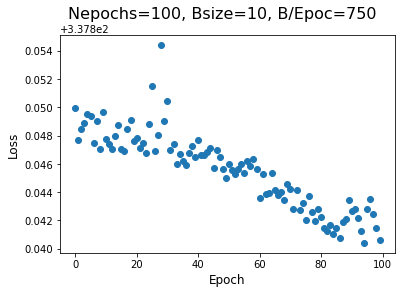

In [16]:
epochArr=range(0,total_epochs);
lossArr = [];
for i in messages_over_time:
    lossArr.append(i.loss.iloc[0])
    
with open('{}_{}_{}_loss.npy'.format(title,batch,batch_per_epoch), 'wb') as f:
    np.save(f, [epochArr,lossArr])
    
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(6,4));

fig.suptitle('Nepochs={}, Bsize={}, B/Epoc={}'.format(total_epochs,batch,batch_per_epoch), fontsize=16)

ax1.plot(epochArr, lossArr, 'o', label='data');
# ax1.set_xscale('log')
# ax1.set_yscale('log')
# ax1.set_ylim(27,28)
# ax1.legend()
# ax1.grid(True)
ax1.set_xlabel('Epoch', fontsize=12);
ax1.set_ylabel('Loss', fontsize=12);

fig.savefig('lossVSepoch_attractive_phi0.6_{}-{}-{}.png'.format(total_epochs,batch,batch_per_epoch))

# **Analysis**

msgs.dtypes x1     float32
y1     float32
vx1    float32
vy1    float32
q1     float32
m1     float32
x2     float32
y2     float32
vx2    float32
vy2    float32
q2     float32
m2     float32
e0     float32
dtype: object
98 messages e1, e2...
msgs.dtypes e99      float32
dx       float32
dy       float32
r        float32
epoch      int64
dtype: object
our test daat set has 1000 samples of 12 edges each (33940, 117)


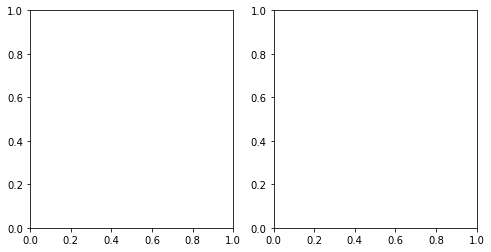

In [17]:

#Only turn on one of these:
plot_force_components = True
plot_sparsity = False
plot_rotation = False
if plot_force_components:
    fig, ax = plt.subplots(1, dim, figsize=(4*dim, 4))
if plot_sparsity or plot_rotation:
    fig, ax = plt.subplots(1, 1)
cam = Camera(fig)


last_alpha_x1 = 0.0
last_alpha_y1 = 0.0


msgs = copy(messages_over_time[0])
print('msgs.dtypes',msgs.dtypes[0:13])
print('98 messages e1, e2...')
print('msgs.dtypes',msgs.dtypes[-6:-1])
print('our test daat set has 1000 samples of 12 edges each',np.shape(msgs))


In [18]:


t = lambda _: _#tqdm
ii=0;
for i in t(range(0, len(messages_over_time), 1)): #len(messages_over_time) number of epochs
    
    msgs = copy(messages_over_time[i])

    msgs['bd'] = msgs.r + 1e-2 # distance between two particles, I guess we sum 1e-2 to prevent divisions by 0?

    #we take only the messages corresponding to forces
    try:
        msg_columns = ['e%d'%(k) for k in range(1, msg_dim+1)]
        msg_array = np.array(msgs[msg_columns])
    except:
        msg_columns = ['e%d'%(k) for k in range(msg_dim)]
        msg_array = np.array(msgs[msg_columns])

    msg_importance = msg_array.std(axis=0)
    most_important = np.argsort(msg_importance)[-dim:]
    print('most_important',most_important)
    msgs_to_compare = msg_array[:, most_important]
    msgs_to_compare = (msgs_to_compare - np.average(msgs_to_compare, axis=0)) / np.std(msgs_to_compare, axis=0)

    if plot_sparsity:
        ax.pcolormesh(msg_importance[np.argsort(msg_importance)[::-1][None, :15]], cmap='gray_r', edgecolors='k')
        # plt.colorbar()
        plt.axis('off')
        plt.grid(True)
        ax.set_aspect('equal')
        plt.text(15.5, 0.5, '...', fontsize=30)
        # fig.suptitle(title + test + 'mse=%.3e'%(min_result.fun/len(msgs),))
        plt.tight_layout()
    
    if plot_force_components or plot_rotation:
        pos_cols = ['dx', 'dy']
        if dim == 3:
            pos_cols.append('dz')

        if sim == 'spring':
            force_fnc = lambda msg: -(msg.bd - 1)[:, None] * np.array(msg[pos_cols]) / msg.bd[:, None]
        elif sim == 'r2':
            force_fnc = lambda msg: np.array(msg[pos_cols]) / (msg.bd[:, None])**3.0 #masses equal to 1
        elif sim == 'BD':
            force_fnc = lambda msg: 24.0 * np.array(msg[pos_cols]) * ( (msg.bd[:, None])**6.0 - 2.0) / (msg.bd[:, None])**13.0 #masses equal to 1
        else:
            raise NotImplementedError("The current force function is not implemented. You will need to change the force function below to that expected by your simulation.")
        
        expected_forces = force_fnc(msgs)

        def percentile_sum(x):
            x = x.ravel()
            bot = x.min()
            top = np.percentile(x, 90)
            msk = (x>=bot) & (x<=top)
            frac_good = (msk).sum()/len(x)
            return x[msk].sum()/frac_good

        from scipy.optimize import minimize

        def linear_transformation_2d(alpha):

            lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1]) + alpha[2]
            lincomb2 = (alpha[3] * expected_forces[:, 0] + alpha[4] * expected_forces[:, 1]) + alpha[5]

            score = (
                percentile_sum(np.square(msgs_to_compare[:, 0] - lincomb1)) +
                percentile_sum(np.square(msgs_to_compare[:, 1] - lincomb2))
            )/2.0

            return score

        def out_linear_transformation_2d(alpha):
            lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1]) + alpha[2]
            lincomb2 = (alpha[3] * expected_forces[:, 0] + alpha[4] * expected_forces[:, 1]) + alpha[5]

            return lincomb1, lincomb2

        def linear_transformation_3d(alpha):

            lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1] + alpha[2] * expected_forces[:, 2]) + alpha[3]
            lincomb2 = (alpha[0+4] * expected_forces[:, 0] + alpha[1+4] * expected_forces[:, 1] + alpha[2+4] * expected_forces[:, 2]) + alpha[3+4]
            lincomb3 = (alpha[0+8] * expected_forces[:, 0] + alpha[1+8] * expected_forces[:, 1] + alpha[2+8] * expected_forces[:, 2]) + alpha[3+8]

            score = (
                percentile_sum(np.square(msgs_to_compare[:, 0] - lincomb1)) +
                percentile_sum(np.square(msgs_to_compare[:, 1] - lincomb2)) +
                percentile_sum(np.square(msgs_to_compare[:, 2] - lincomb3))
            )/3.0

            return score

        def out_linear_transformation_3d(alpha):

            lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1] + alpha[2] * expected_forces[:, 2]) + alpha[3]
            lincomb2 = (alpha[0+4] * expected_forces[:, 0] + alpha[1+4] * expected_forces[:, 1] + alpha[2+4] * expected_forces[:, 2]) + alpha[3+4]
            lincomb3 = (alpha[0+8] * expected_forces[:, 0] + alpha[1+8] * expected_forces[:, 1] + alpha[2+8] * expected_forces[:, 2]) + alpha[3+8]

            return lincomb1, lincomb2, lincomb3

        if dim == 2:
            min_result = minimize(linear_transformation_2d, np.ones(dim**2 + dim), method='Powell')
        if dim == 3:
            min_result = minimize(linear_transformation_3d, np.ones(dim**2 + dim), method='Powell')
        print(title, test, 'gets', min_result.fun/len(msgs))

        if plot_rotation:
            q = min_result.x
            alphax1, alphay1, offset1 = q[:3]
            alphax2, alphay2, offset2 = q[3:]
            
            s1 = alphax1**2 + alphay1**2
            s2 = alphax2**2 + alphay2**2
            
            if ((alphax2 - last_alpha_x1)**2 + (alphay2 - last_alpha_y1)**2  < (alphax1 - last_alpha_x1)**2 + (alphay1 - last_alpha_y1)**2):
                alphax1, alphay1, offset1 = q[3:]
                alphax2, alphay2, offset2 = q[:3]
                
            last_alpha_x1 = alphax1
            last_alpha_y1 = alphay1
            s1 = alphax1**2 + alphay1**2
            s2 = alphax2**2 + alphay2**2
            alphax1 /= s1**0.5 * 2
            alphay1 /= s1**0.5 * 2
            alphax2 /= s2**0.5 * 2
            alphay2 /= s2**0.5 * 2
            
            ax.arrow(0.5, 0.5, alphax1, alphay1, color='k', head_width=0.05, length_includes_head=True)
            ax.arrow(0.5, 0.5, alphax2, alphay2, color='k', head_width=0.05, length_includes_head=True)
            ax.axis('off')
        
        if plot_force_components:
            for i in range(dim):
                if dim == 3:
                    px = out_linear_transformation_3d(min_result.x)[i]
                else:
                    px = out_linear_transformation_2d(min_result.x)[i]

                py = msgs_to_compare[:, i]
                ax[i].scatter(px, py,
                              alpha=0.1, s=0.1, color='k')
                ax[i].set_xlabel('Linear combination of forces')
                ax[i].set_ylabel('Message Element %d'%(i+1))

                xlim = np.array([np.percentile(px, q) for q in [10, 90]])
                ylim = np.array([np.percentile(py, q) for q in [10, 90]])
                xlim[0], xlim[1] = xlim[0] - (xlim[1] - xlim[0])*0.05, xlim[1] + (xlim[1] - xlim[0])*0.05
                ylim[0], ylim[1] = ylim[0] - (ylim[1] - ylim[0])*0.05, ylim[1] + (ylim[1] - ylim[0])*0.05

                ax[i].set_xlim(xlim)
                ax[i].set_ylim(ylim)
                
#                 ax[i].set_xlim((-1,1))
#                 ax[i].set_ylim((-1,1))
                
        plt.tight_layout()
    
    cam.snap()
    
    ii+=1;
    if (ii % 5) == 0:
        clear_output(wait=True)
    
ani = cam.animate()
    
from IPython.display import HTML
HTML(ani.to_jshtml())

<Figure size 432x288 with 0 Axes>

In [ ]:
# For CPU

from simulate import make_transparent_color
from scipy.integrate import odeint

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
camera = Camera(fig)

x_times=[];

for current_model in [0,total_epochs-1]: # current_model<=-2 corresponds to Random model!
    i = 1 #4 #2 #Use this simulation
    if current_model > total_epochs-1:
        continue

    #Truth:
    cutoff_time =  nt//2  #300
    times = onp.array(range(1,100000))[:cutoff_time]
    x_times = onp.array(data_attr[0, :cutoff_time,:,:])
#     masses = x_times[:, :, -1]
    length_of_tail = 75

    #Learned:
    e = get_edge_index_cutoff(1,1,d_cutoff_TF=False).cpu() #change by d_cutoff_TF=True???
#     ogn.cpu()
    if current_model > -2:
#         ogn.load_state_dict(recorded_models[current_model])
        load_file = os.path.join(saving_folder, 'epoch-{0}.pth'.format(current_model))
        print('loading ',load_file)
        ogn.load_state_dict(torch.load(load_file))
        
        
    else:
        # Random model!
        ogn = OGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cpu()
#     ogn_new.cpu()
    
    def odefunc(y, t=None):
        y = y.reshape(n, 6).astype(np.float32)
        cur = Data(
            x=torch.from_numpy(y).cpu(),
            edge_index=e
        )
        dx = y[:, 2:4]
        dv = ogn.just_derivative(cur).cpu().detach().numpy()
        dother = np.zeros_like(dx)
        return np.concatenate((dx, dv, dother), axis=1).ravel()

    datai = odeint(odefunc, (onp.asarray(x_times[0]).ravel()), times).reshape(-1, n, 6)
    x_times2 = onp.array(datai)

    d_idx = 10
    for t_idx in range(d_idx, cutoff_time, d_idx):
        start = max([0, t_idx-length_of_tail])
        ctimes = times[start:t_idx]
        cx_times = x_times[start:t_idx]
        cx_times2 = x_times2[start:t_idx]
        for j in range(n):
            rgba = make_transparent_color(len(ctimes), j/n)
            ax[0].scatter(cx_times[:, j, 0], cx_times[:, j, 1], color=rgba) #left plot is the true movement
            ax[1].scatter(cx_times2[:, j, 0], cx_times2[:, j, 1], color=rgba) #right plot predicted movement
            black_rgba = rgba
            black_rgba[:, :3] = 0.75
            ax[1].scatter(cx_times[:, j, 0], cx_times[:, j, 1], color=black_rgba, zorder=-1) # right plot grey -> true movement

        for k in range(2):
            ax[k].set_xlim(-3, 3)
            ax[k].set_ylim(-3, 3)
        plt.tight_layout()
        camera.snap()
        
        if t_idx > cutoff_time-d_idx:
            fig.title('current_model {0}'.format(current_model))

# camera.animate().save('multiple_animations_with_comparison.mp4')
from IPython.display import HTML
HTML(camera.animate().to_jshtml())



In [19]:
# messages_over_time = [0,1,2,3,4,5]

for i in t(range(0, total_epochs, 1)): #len(messages_over_time) number of epochs
    
    load_file = os.path.join(saving_folder, 'epoch-{0}.pth'.format(i))
    print('loading ',load_file)
    ogn.load_state_dict(torch.load(load_file))
    cur_msgs = get_messages(ogn)
    
    msgs = copy(cur_msgs)

    msgs['bd'] = msgs.r + 1e-2 # distance between two particles, I guess we sum 1e-2 to prevent divisions by 0?

    #we take only the messages corresponding to forces
    try:
        msg_columns = ['e%d'%(k) for k in range(1, msg_dim+1)]
        msg_array = np.array(msgs[msg_columns])
    except:
        msg_columns = ['e%d'%(k) for k in range(msg_dim)]
        msg_array = np.array(msgs[msg_columns])

    msg_importance = msg_array.std(axis=0)
    most_important = np.argsort(msg_importance)[-dim:]
    print('most_important',most_important)
    msgs_to_compare = msg_array[:, most_important]
    msgs_to_compare = (msgs_to_compare - np.average(msgs_to_compare, axis=0)) / np.std(msgs_to_compare, axis=0)
    
    clear_output(wait=True)

    
newtestloader_2 = DataLoader(
    [Data(
        X_test[i],
        edge_index=get_edge_index_cutoff(X_test[i],d_cutoff,d_cutoff_TF=False),
        y=y_test[i]) for i in test_idxes],
    batch_size=len(X_test),
    shuffle=False
)

print(np.shape(X_test))

i=0
for ginput_plot_all in newtestloader_2:     # Trainloader has the 1500 samples (pos vel edge index, ...).
    print('i ', i)
    if i >= 2:
        print('break')
        break

    print('number of messages if fully connected graphs: ', num_graphs_test*n*(n-1))
    print(np.shape(ginput_plot_all.edge_index))
    i+=1
    
    
    
newtestloader_3 = DataLoader(
    [Data(
        X_test[i],
        edge_index=get_edge_index_cutoff(X_test[i],d_cutoff,d_cutoff_TF=d_cutoff_TF),
        y=y_test[i]) for i in test_idxes],
    batch_size=len(X_test),
    shuffle=False
)

print(np.shape(X_test))

i=0
for ginput_plot_cutoff in newtestloader_3:     # Trainloader has the 1500 samples (pos vel edge index, ...).
    print('i ', i)
    if i >= 2:
        print('break')
        break

    print('number of messages if fully connected graphs: ', num_graphs_test*n*(n-1))
    print(np.shape(ginput_plot_cutoff.edge_index))
    i+=1
    
    

torch.Size([2500, 25, 6])
i  0
number of messages if fully connected graphs:  600000
torch.Size([2, 600000])
torch.Size([2500, 25, 6])
i  0
number of messages if fully connected graphs:  600000
torch.Size([2, 34192])


/home/barri/miniconda3/envs/mlam_cpu/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: overflow encountered in power


np.shape(s1) torch.Size([600000, 6])
np.shape(s2) torch.Size([600000, 6])
np.shape(distance) (600000, 2)
np.shape(distance_mod) (600000,)


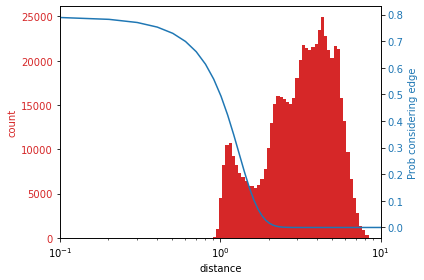

loading  BD_n=25_dim=2_nt=100000_dt=0.01_ns=1_epochs_100_d_cutoff_smooth_1.00_d_cutoff_smth_0.75/epoch-0.pth
ogn.edge_index[0] tensor(0)
np.shape(force_mod) (600000,)


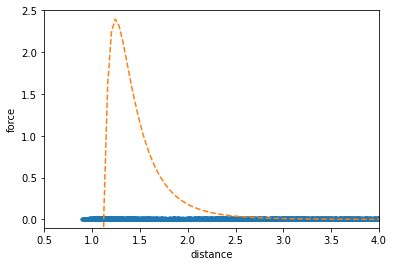

loading  BD_n=25_dim=2_nt=100000_dt=0.01_ns=1_epochs_100_d_cutoff_smooth_1.00_d_cutoff_smth_0.75/epoch-99.pth
ogn.edge_index[0] tensor(0)
np.shape(force_mod) (600000,)


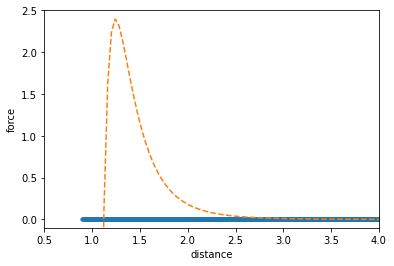

In [21]:


# TRYING TO PLOT THE FORCE

def plotting_force(ginput_plot, epoch_pl_list = [0,2]):

    s1 = ginput_plot.x[ginput_plot.edge_index[0,:]]
    s2 = ginput_plot.x[ginput_plot.edge_index[1,:]]
    
    print('np.shape(s1)',np.shape(s1))
    print('np.shape(s2)',np.shape(s2))
    
    distance = (s1[:,0:2]-s2[:,0:2]).detach().numpy()
    print('np.shape(distance)',np.shape(distance))
    distance_mod = np.linalg.norm(distance,axis=1)
    print('np.shape(distance_mod)',np.shape(distance_mod)) 

    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('distance')
    ax1.set_ylabel('count', color=color)
    logbins = np.logspace(np.log10(min(distance_mod)),np.log10(max(distance_mod)),50)
    ax1.hist(distance_mod, bins = logbins, color=color)
    ax1.set_xscale('log')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'

    x_pl = np.linspace(0,10,100)
    y_pl = fermi_func(x_pl**2)
    ax2.plot(x_pl,y_pl)
    ax2.set_ylabel('Prob considering edge', color=color)  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor=color)

    ax2.set_xlim((0.1,10))
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

    fig.savefig('histo_attractive_phi{}_{}-{}-{}.png'.format(density,total_epochs,batch,batch_per_epoch))    
      
    for epoch_pl in epoch_pl_list:

        load_file = os.path.join(saving_folder, 'epoch-{0}.pth'.format(epoch_pl))
        print('loading ',load_file)
        ogn.load_state_dict(torch.load(load_file))
        print('ogn.edge_index[0]',ogn.edge_index[0,0])

        force = ogn.message(s1, s2)[:,most_important].detach().numpy()
        force_mod = np.linalg.norm(force,axis=1)
        print('np.shape(force_mod)',np.shape(force_mod))
    
        fig, ax3 = plt.subplots()
        plt.plot(distance_mod,force_mod,'.')
        xxx = np.linspace(0.1, 4, 100)
        yyy = 24*(xxx**6-2)/xxx**13 # 1/xxx**2
        plt.plot(xxx,yyy,'--')

        ax3 = plt.gca()
        ax3.set_xscale('linear')
        ax3.set_yscale('linear')
        plt.xlabel('distance')
        plt.ylabel('force')
        plt.xlim((0.5,4))
        plt.ylim((-0.1,2.5))        
        plt.show()
        
        fig.savefig('force_attractive_phi{}_{}-{}-{}_{}_all.png'.format(density,total_epochs,batch,batch_per_epoch,epoch_pl))    
    
plotting_force(ginput_plot_all, epoch_pl_list = [0,total_epochs-1])
# plotting_force(ginput_plot_cutoff, epoch_pl_list = [0,total_epochs-1])




NameError: name 'nParts' is not defined

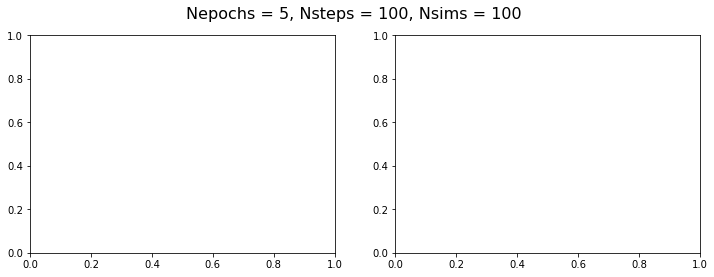

In [42]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

fig.suptitle('Nepochs = 5, Nsteps = 100, Nsims = 100', fontsize=16)

ax1.plot(nParts, execTime, 'o', label='data')
ax1.plot(nParts, 10*onp.square(nParts), '-', label='$n^2$')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylim(90,1100)
ax1.legend()
# ax1.grid(True)
ax1.set_xlabel('Number of particles', fontsize=12)
ax1.set_ylabel('Training time', fontsize=12)
#ax1.axes.get_xaxis().set_visible(False)

ax2.plot(nParts, curloss, 'o', label='data')
ax2.plot(nParts, 0.001*onp.power(nParts,3), '-', label='$l^3$')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_ylim(0.08,1.1)
ax2.legend()
ax2.set_xlabel('Number of particles', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)

In [ ]:
# # For GPU

# fig, ax = plt.subplots(1, 2, figsize=(8, 4))
# camera = Camera(fig)

# for current_model in [-1] + [1, 34, 67, 100, 133, 166, 199]:
#     i = 4 #Use this simulation
#     if current_model > len(recorded_models):
#         continue

#     #Truth:
#     cutoff_time = 300
#     times = onp.array(s.times)[:cutoff_time]
#     x_times = onp.array(data[i, :cutoff_time])
#     masses = x_times[:, :, -1]
#     length_of_tail = 75

#     #Learned:
#     e = edge_index.cuda()
#     ogn.cpu()
#     if current_model > -1:
#         ogn.load_state_dict(recorded_models[current_model])
#     else:
#         # Random model!
#         ogn = OGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cuda()
#     ogn.cuda()
    
#     def odefunc(y, t=None):
#         y = y.reshape(n, 6).astype(np.float32)
#         cur = Data(
#             x=torch.from_numpy(y).cuda(),
#             edge_index=e
#         )
#         dx = y[:, 2:4]
#         dv = ogn.just_derivative(cur).cpu().detach().numpy()
#         dother = np.zeros_like(dx)
#         return np.concatenate((dx, dv, dother), axis=1).ravel()

#     datai = odeint(odefunc, (onp.asarray(x_times[0]).ravel()), times).reshape(-1, n, 6)
#     x_times2 = onp.array(datai)

#     d_idx = 10
#     for t_idx in range(d_idx, cutoff_time, d_idx):
#         start = max([0, t_idx-length_of_tail])
#         ctimes = times[start:t_idx]
#         cx_times = x_times[start:t_idx]
#         cx_times2 = x_times2[start:t_idx]
#         for j in range(n):
#             rgba = make_transparent_color(len(ctimes), j/n)
#             ax[0].scatter(cx_times[:, j, 0], cx_times[:, j, 1], color=rgba)
#             ax[1].scatter(cx_times2[:, j, 0], cx_times2[:, j, 1], color=rgba)
#             black_rgba = rgba
#             black_rgba[:, :3] = 0.75
#             ax[1].scatter(cx_times[:, j, 0], cx_times[:, j, 1], color=black_rgba, zorder=-1)

#         for k in range(2):
#             ax[k].set_xlim(-1, 3)
#             ax[k].set_ylim(-3, 1)
#         plt.tight_layout()
#         camera.snap()

# # camera.animate().save('multiple_animations_with_comparison.mp4')
# from IPython.display import HTML
# HTML(camera.animate().to_jshtml())

In [ ]:
#######################
# Symbolic regression #
#######################

In [ ]:
# Finally, one can install a free 30-day trial of Eureqa at this URL: https://www.nutonian.com/download/eureqa-desktop-download/.

# Extract the force laws with the following procedure:

#     The data in messages_over_time correspond to inputs to, and features of, ϕe, recorded during each training epoch.
#     Select the last element of this list.
#     Find the most significant message feature. Each message feature corresponds to 'e1', 'e2', etc. Calculate the one with the largest standard deviation.
#     Save that message to csv file along with the input features. Paste these into the data column of Eureqa (it's a GUI app).
#     Don't change anything on the "prepare data" tab.
#     Enable your choice of operators with complexity levels for each (this choice is up to you).
#     Set the loss to mean absolute error (the default) and begin training.
#     After you start training, you will be able to see a table of equations as a function of complexity and fit to the data. These represent a symbolic representation of the message function.
#     Find the equation that has the greatest drop in log mean absolute error over increase in complexity. This equation should be equal to a linear transform of the true force.

# Thus, we have extracted a force law from the graph network without priors on the functional form.

# This is the same technique we used to extract the unknown dark matter overdensity equation from the Quijote simulations

In [ ]:
# Here's the best message, which we will study:
best_message = np.argmax([np.std(messages_over_time[-1]['e%d'%(i,)]) for i in range(100)])

In [ ]:
# Here's a pandas dataframe of the message data:
messages_over_time[-1][['e%d'%(best_message,), 'dx', 'dy', 'r', 'm1', 'm2']]

In [ ]:
# Now we just fit e4 as a function of dx, dy, r, m1, and m2, inside Eureqa.